In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.models import KantorovichGapModel
from entot.models.utils import MixtureNormalSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import scanpy as sc

2023-06-20 07:45:52.933686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata = sc.read("/home/dominikk/data/pancreas_multiome_2022_processed.h5ad")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


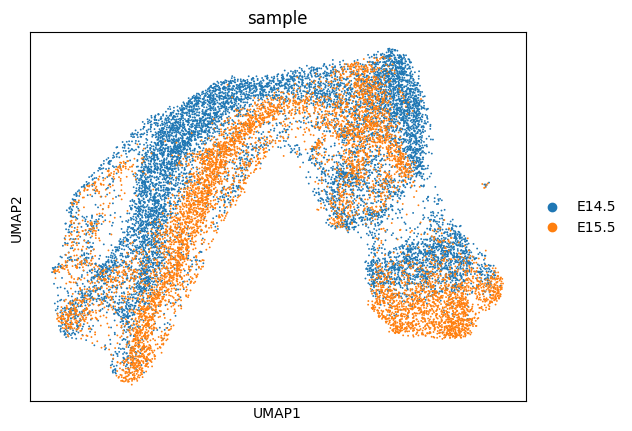

In [4]:
sc.pl.umap(adata, color="sample")

In [5]:
adata = adata[:, adata.var["modality"]=="GEX"]


In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=10)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
sc.pp.pca(adata, n_comps=10)

In [9]:
source = adata[adata.obs["sample"]=="E14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["sample"]=="E15.5"].obsm["X_pca"].copy()

In [35]:

from entot.models.utils import MLP
from entot.models.utils import MixtureNormalSampler, Simple_MLP
import flax.linen as nn

mlp_eta = Simple_MLP([64, 64, 64], nn.selu, 1, nn.relu)
mlp_xi = Simple_MLP([64, 64, 64], nn.selu, 1, nn.relu)
unbalanced_kwargs= {"tau_a": 0.998, "tau_b": 0.998, "epsilon": 1e-3, "model": 1}

In [43]:
kg = KantorovichGapModel(epsilon_kant_gap=0.1, mlp_eta=mlp_eta, mlp_xi=mlp_xi, unbalanced_kwargs=unbalanced_kwargs, input_dim=[10], k_noise_per_x=1, iterations=3, lambda_kant_gap=10)

In [44]:
kg(source, target, 1024, 1024)

One epoch consists of 9.5810546875 iterations


100%|██████████| 3/3 [00:12<00:00,  4.26s/it]


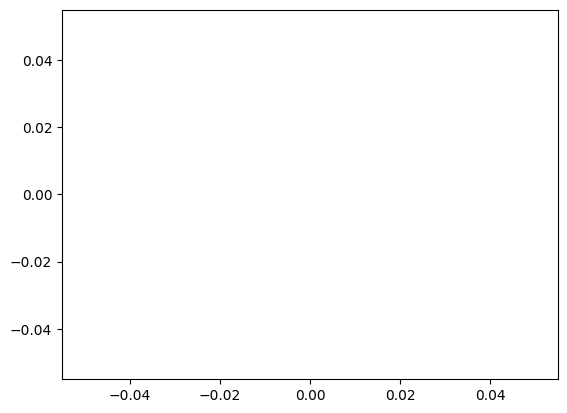

: 

In [45]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["total_loss"])

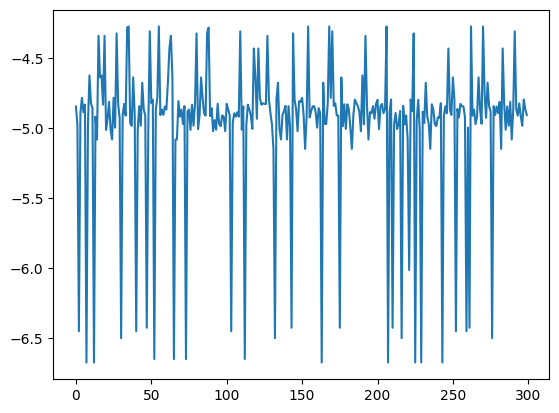

In [30]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])

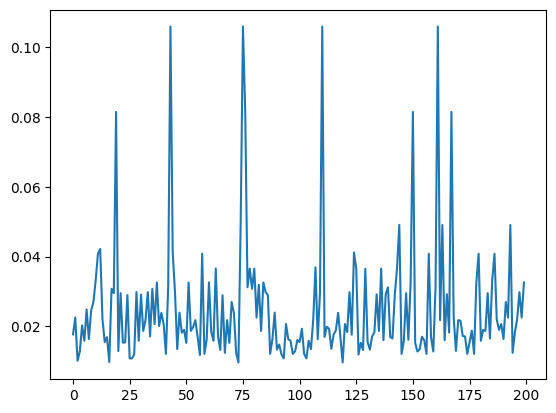

In [34]:
plt.plot(np.arange(len(kg.metrics["total_loss"][100:])), kg.metrics["loss_xi"][100:])

In [28]:
pushed = kg.transport(source, 100, 0)

In [29]:
pushed

Array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [136]:
pushed_mean = jnp.mean(pushed, axis=0)
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((jnp.squeeze(pushed_mean), target), axis=0)

In [137]:
del bdata.uns
del bdata.obsp

In [138]:
bdata.obsm

AxisArrays with keys: X_pca, X_pca_wsnn, X_spca_wsnn, X_umap, X_umap_ATAC, X_umap_GEX, X_umap_wsnn, lsi_full, lsi_red, umap, umap_ATAC, umap_GEX, X_pca_result

# Check the fitting term

In [139]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

In [140]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


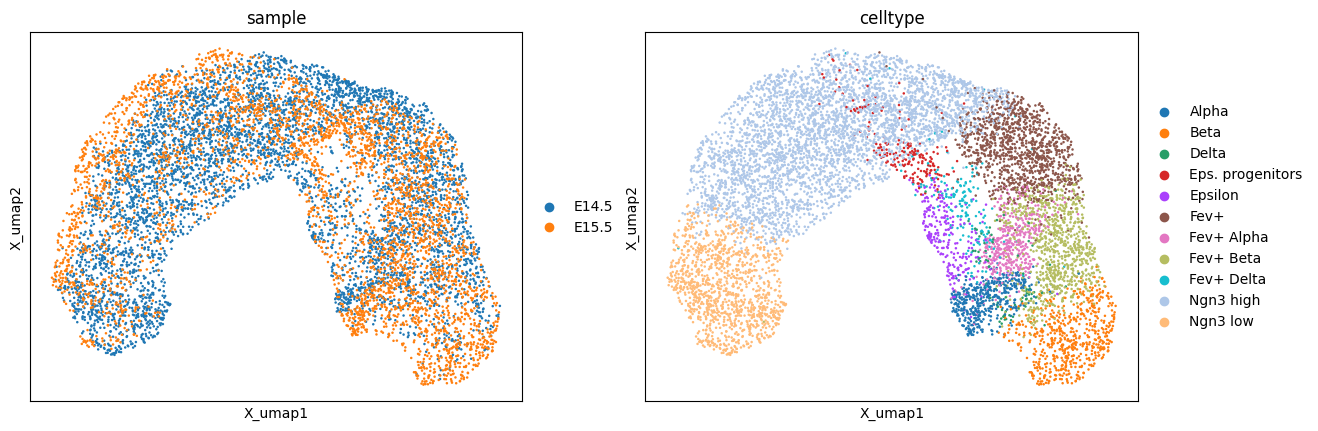

In [141]:
sc.pl.embedding(bdata, basis="X_umap", color=["sample", "celltype"])

# Check the variances

In [142]:
adata_early = adata[adata.obs["sample"]=="E14.5"]
adata_late = adata[adata.obs["sample"]=="E15.5"]

## Check variances on source+target

In [143]:
from entot.metrics.metrics import compute_directional_statistics_from_samples, compute_statistics_from_samples

In [145]:
res = compute_statistics_from_samples(pushed, 10, adata_early.obs_names)

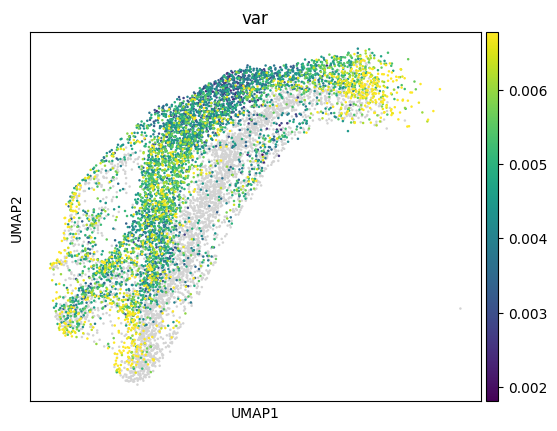

In [146]:
adata.obs["var"] = res["mean_of_variance"]
sc.pl.umap(adata, color="var", vmax="p90")

In [147]:
adata_early.obs = adata_early.obs.merge(res, how="left", left_index=True, right_index=True)

In [148]:
df_vars =adata_early.obs[["celltype", "var_of_variance", "mean_of_variance"]].groupby("celltype").mean()

In [149]:
order_celltypes = ["Alpha", "Beta", "Delta", "Epsilon", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+", "Eps. progenitors", "Ngn3 high", "Ngn3 low"]
df_vars = df_vars.reindex(order_celltypes)

/tmp/ipykernel_757548/2753713755.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df_vars.index, rotation = 90)
/tmp/ipykernel_757548/2753713755.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_vars.index, rotation = 90)


[Text(0, 0, 'Alpha'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Delta'),
 Text(3, 0, 'Epsilon'),
 Text(4, 0, 'Fev+ Alpha'),
 Text(5, 0, 'Fev+ Beta'),
 Text(6, 0, 'Fev+ Delta'),
 Text(7, 0, 'Fev+'),
 Text(8, 0, 'Eps. progenitors'),
 Text(9, 0, 'Ngn3 high'),
 Text(10, 0, 'Ngn3 low')]

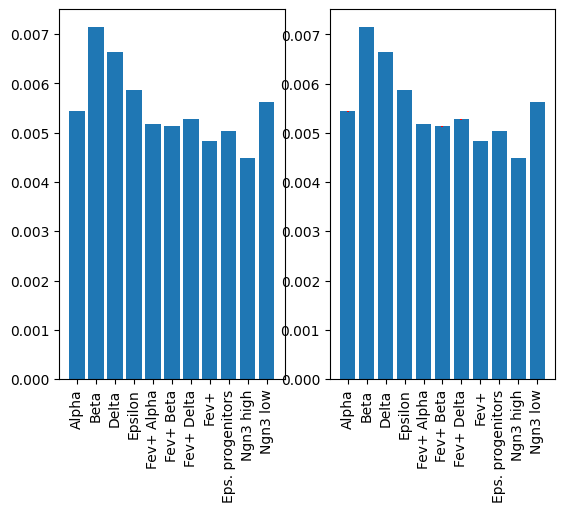

In [150]:
fig, axes = plt.subplots(1, 2)

axes[0].bar(df_vars.index, df_vars["mean_of_variance"], error_kw=dict(ecolor='r'))
axes[0].set_xticklabels(df_vars.index, rotation = 90)

axes[1].bar(df_vars.index, df_vars["mean_of_variance"], yerr=df_vars["var_of_variance"], error_kw=dict(ecolor='r'))
axes[1].set_xticklabels(df_vars.index, rotation = 90)

### Directional uncertainty

In [151]:
df_dir, _ = compute_directional_statistics_from_samples(samples, 1, adata_early.obs_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5458 out of 5458 | elapsed:    7.8s finished


In [152]:
df_dir["celltype"] = adata_early.obs["celltype"]

In [153]:
adata.obs["directional_variance"] = df_dir["directional_variance"]
adata.obs["directional_difference"] = df_dir["directional_difference"]
adata.obs["directional_cosine_sim_variance"] = df_dir["directional_cosine_sim_variance"]

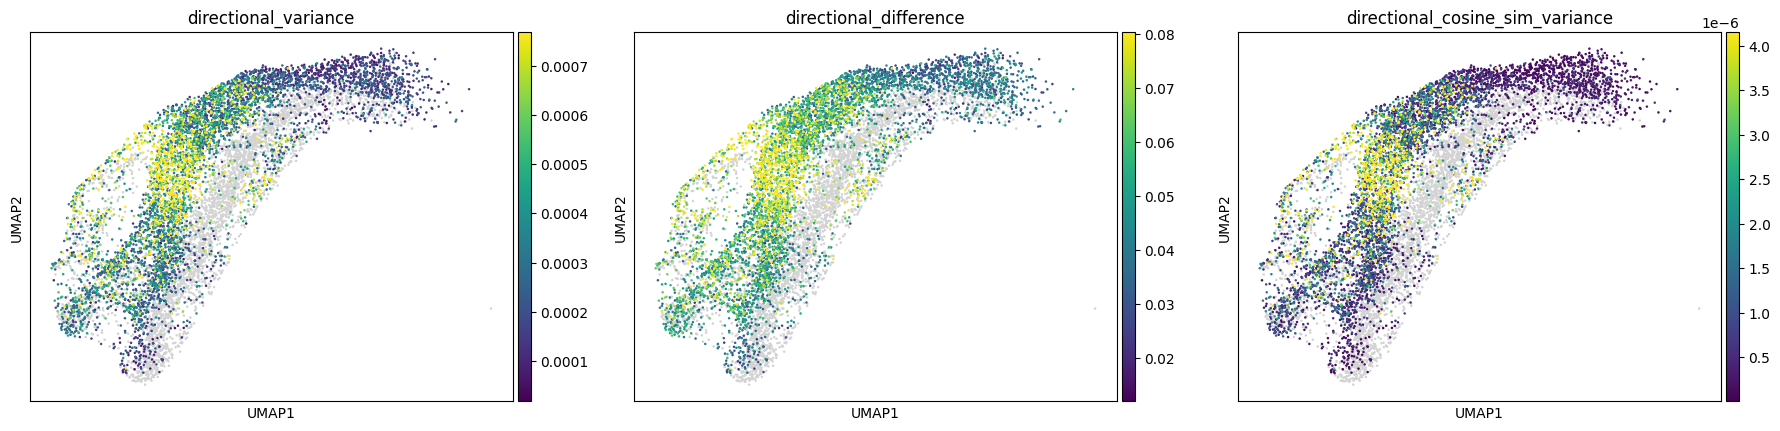

In [154]:
sc.pl.umap(adata, color=["directional_variance", "directional_difference", "directional_cosine_sim_variance"], vmax="p90")

In [98]:
df_vars =df_dir[["celltype", "directional_variance", "directional_difference", "directional_cosine_sim_mean", "directional_cosine_sim_variance"]].groupby("celltype").mean()

In [99]:
order_celltypes = ["Alpha", "Beta", "Delta", "Epsilon", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+", "Eps. progenitors", "Ngn3 high", "Ngn3 low"]
df_vars = df_vars.reindex(order_celltypes)

/tmp/ipykernel_757548/3138520223.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df_vars.index, rotation = 90)
/tmp/ipykernel_757548/3138520223.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_vars.index, rotation = 90)
/tmp/ipykernel_757548/3138520223.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(df_vars.index, rotation = 90)


[Text(0, 0, 'Alpha'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Delta'),
 Text(3, 0, 'Epsilon'),
 Text(4, 0, 'Fev+ Alpha'),
 Text(5, 0, 'Fev+ Beta'),
 Text(6, 0, 'Fev+ Delta'),
 Text(7, 0, 'Fev+'),
 Text(8, 0, 'Eps. progenitors'),
 Text(9, 0, 'Ngn3 high'),
 Text(10, 0, 'Ngn3 low')]

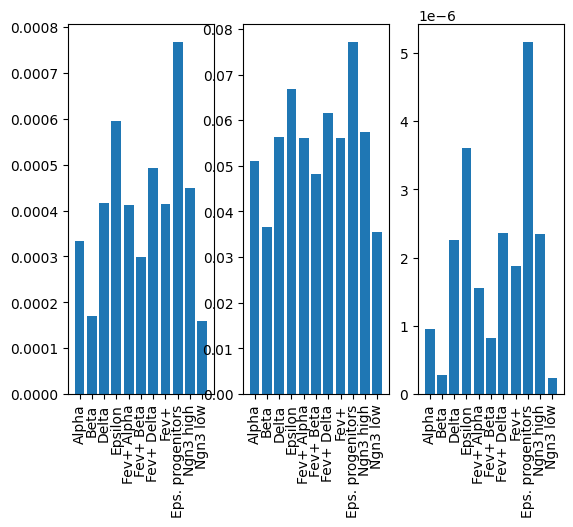

In [100]:
fig, axes = plt.subplots(1, 3)

axes[0].bar(df_vars.index, df_vars["directional_variance"], error_kw=dict(ecolor='r'))
axes[0].set_xticklabels(df_vars.index, rotation = 90)

axes[1].bar(df_vars.index, df_vars["directional_difference"], error_kw=dict(ecolor='r'))
axes[1].set_xticklabels(df_vars.index, rotation = 90)

axes[2].bar(df_vars.index, df_vars["directional_cosine_sim_variance"], error_kw=dict(ecolor='r'))
axes[2].set_xticklabels(df_vars.index, rotation = 90)

## Check variances on source

In [136]:
for j in range(10):
    res = [None] * 15
    for i in range(15):
        noise = jax.random.normal(jax.random.PRNGKey(j*10+i), shape=(len(adata_early), 4))
        source_with_noise = jnp.concatenate((adata_early.obsm["X_pca"], noise), axis=1)
        res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)
    samples = jnp.array(res)
    vars = jnp.var(samples, axis=0)
    vars_summed = jnp.sum(vars, axis=1)
    bdata_early.obs[f"var_{j}"] = np.asarray(vars_summed)

/tmp/ipykernel_43085/1104670147.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata_early.obs[f"var_{j}"] = np.asarray(vars_summed)


In [137]:
ls_vars = []
for j in range(10):
    ls_vars.append(bdata_early[bdata_early.obs["sample"]=="E14.5"].obs[["celltype", f"var_{j}"]].groupby("celltype").mean())

In [138]:
df_vars = pd.concat(ls_vars, axis=1)

In [139]:
var_cols = [f"var_{j}" for j in range(10)]
df_vars['mean_of_vars'] = df_vars[var_cols].mean(axis=1)
df_vars['var_of_vars'] = df_vars[var_cols].var(axis=1)

In [140]:
df_vars = df_vars.reindex(order_celltypes)

/tmp/ipykernel_43085/2473399689.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_vars.index, rotation = 45)


[Text(0, 0, 'Alpha'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Delta'),
 Text(3, 0, 'Epsilon'),
 Text(4, 0, 'Fev+ Alpha'),
 Text(5, 0, 'Fev+ Beta'),
 Text(6, 0, 'Fev+ Delta'),
 Text(7, 0, 'Fev+'),
 Text(8, 0, 'Eps. progenitors'),
 Text(9, 0, 'Ngn3 high'),
 Text(10, 0, 'Ngn3 high cycling'),
 Text(11, 0, 'Ngn3 low')]

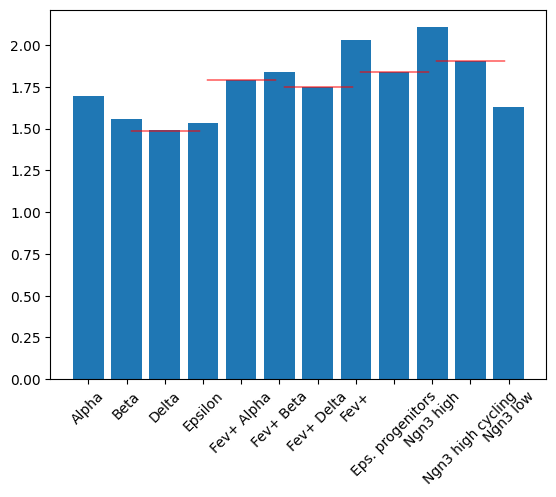

In [141]:
fig = plt.figure(1)
ax = fig.add_subplot(111)

plt.bar(df_vars.index, df_vars["mean_of_vars"], yerr=df_vars["var_of_vars"], error_kw=dict(elinewidth=50, ecolor='r'))
ax.set_xticklabels(df_vars.index, rotation = 45)

## Check variances on target

In [142]:
for j in range(10):
    res = [None] * 15
    for i in range(15):
        noise = jax.random.normal(jax.random.PRNGKey(j*10+i), shape=(len(adata_late), 4))
        source_with_noise = jnp.concatenate((adata_late.obsm["X_pca"], noise), axis=1)
        res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)
    samples = jnp.array(res)
    vars = jnp.var(samples, axis=0)
    vars_summed = jnp.sum(vars, axis=1)
    bdata_late.obs[f"var_{j}"] = np.asarray(vars_summed)

/tmp/ipykernel_43085/2917803366.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata_late.obs[f"var_{j}"] = np.asarray(vars_summed)


In [150]:
ls_vars = []
for j in range(10):
    ls_vars.append(bdata_late.obs[["celltype", f"var_{j}"]].groupby("celltype").mean())

In [151]:
df_vars = pd.concat(ls_vars, axis=1)

In [152]:
var_cols = [f"var_{j}" for j in range(10)]
df_vars['mean_of_vars'] = df_vars[var_cols].mean(axis=1)
df_vars['var_of_vars'] = df_vars[var_cols].var(axis=1)

In [153]:
df_vars = df_vars.reindex(order_celltypes)

/tmp/ipykernel_43085/2473399689.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_vars.index, rotation = 45)


[Text(0, 0, 'Alpha'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Delta'),
 Text(3, 0, 'Epsilon'),
 Text(4, 0, 'Fev+ Alpha'),
 Text(5, 0, 'Fev+ Beta'),
 Text(6, 0, 'Fev+ Delta'),
 Text(7, 0, 'Fev+'),
 Text(8, 0, 'Eps. progenitors'),
 Text(9, 0, 'Ngn3 high'),
 Text(10, 0, 'Ngn3 high cycling'),
 Text(11, 0, 'Ngn3 low')]

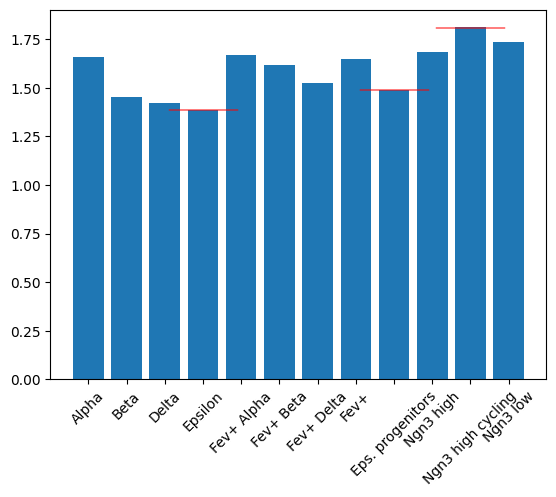

In [155]:
fig = plt.figure(1)
ax = fig.add_subplot(111)

plt.bar(df_vars.index, df_vars["mean_of_vars"], yerr=df_vars["var_of_vars"], error_kw=dict(elinewidth=50, ecolor='r'))
ax.set_xticklabels(df_vars.index, rotation = 45)

# Check accuracy of the model

In [99]:
from typing import Callable, Optional, Tuple, Union, List
import scipy.sparse as sp


def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  # type:ignore[override]
        transport_map: Callable[[jnp.ndarray], jnp.ndarray],
        src_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
        length_scale: Optional[float] = None,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(src_cells), batch_size):
            distances, indices = get_knn_fn(transport_map(src_cells[index : index + batch_size]), tgt_cells, k)
            distances_list.append(float(distances.flatten()>1))
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(src_cells) - index)), min(k, len(tgt_cells)))
            )
        distances = jnp.concatenate(distances_list)
        row_indices = jnp.concatenate(row_indices)
        column_indices = jnp.concatenate(column_indices)
        tm = sp.csr_matrix((distances, (row_indices, column_indices)), shape=[len(src_cells), len(tgt_cells)])
        return tm

In [103]:
source = adata[adata.obs["sample"]=="E14.5"].obsm["X_pca"]
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(len(source), 4))
source_with_noise = jnp.concatenate((source, noise), axis=1)
pushed = kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)

r = lambda x: kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, x)
key = jax.random.PRNGKey(0)
src_batch = jax.random.choice(key, source_with_noise.shape[0], shape=((1024,)))
r2 = r(source_with_noise[src_batch][:,])

In [104]:
tm = project_transport_matrix(lambda x: kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, x), source_with_noise, target)

In [105]:
tm_df = pd.DataFrame(data=tm.A, index=adata[adata.obs["sample"]=="E14.5"].obs.index, columns = adata[adata.obs["sample"]=="E15.5"].obs.index)

In [108]:
adata_early = adata[adata.obs["sample"]=="E14.5"]
adata_late = adata[adata.obs["sample"]=="E15.5"]

df_res = pd.DataFrame(index=adata_early.obs["celltype"].cat.categories)
for ct in adata_late.obs["celltype"].cat.categories:
    cols_cell_type = adata_late[adata_late.obs["celltype"] == ct].obs.index
    for ct2 in adata_early.obs["celltype"].cat.categories:
        index_cell_type = adata_early[adata_early.obs["celltype"] == ct2].obs.index
        df_res.loc[ct2, ct] = tm_df.loc[index_cell_type, cols_cell_type].sum().sum()


In [112]:
cell_transition = df_res.div(df_res.sum(axis=1), axis=0)
cell_transition

,Alpha,Beta,Delta,Eps. progenitors,Epsilon,Fev+,Fev+ Alpha,Fev+ Beta,Fev+ Delta,Ngn3 high,Ngn3 high cycling,Ngn3 low
Alpha,0.670501,0.115404,0.018857,0.000000,0.013657,0.000710,0.106561,0.071974,0.002337,0.000000,0.000000,0.000000
Beta,0.002806,0.959694,0.000503,0.000000,0.000000,0.000000,0.000905,0.035957,0.000136,0.000000,0.000000,0.000000
Delta,0.086849,0.335414,0.150165,0.000000,0.024111,0.004742,0.094616,0.269629,0.034473,0.000000,0.000000,0.000000
Eps. progenitors,0.000008,0.000000,0.000399,0.386348,0.090466,0.017630,0.000245,0.000712,0.086086,0.418107,0.000000,0.000000
Epsilon,0.150883,0.014188,0.046286,0.046032,0.498196,0.006285,0.058017,0.019754,0.157121,0.003238,0.000000,0.000000
Fev+,0.000083,0.000882,0.001402,0.000250,0.000613,0.731789,0.046866,0.180191,0.002903,0.032207,0.002784,0.000031
Fev+ Alpha,0.126279,0.015406,0.017044,0.000004,0.003604,0.036239,0.427179,0.349857,0.020540,0.000097,0.003752,0.000000
Fev+ Beta,0.005178,0.225172,0.003542,0.000000,0.000000,0.045654,0.043854,0.673406,0.000970,0.000054,0.000000,0.002169
Fev+ Delta,0.054551,0.012045,0.078311,0.053213,0.151143,0.110577,0.137132,0.108922,0.238195,0.055911,0.000000,0.000000
Ngn3 high,0.000000,0.000018,0.000018,0.017869,0.000048,0.050975,0.000283,0.000459,0.001344,0.922823,0.000974,0.005190


<Axes: >

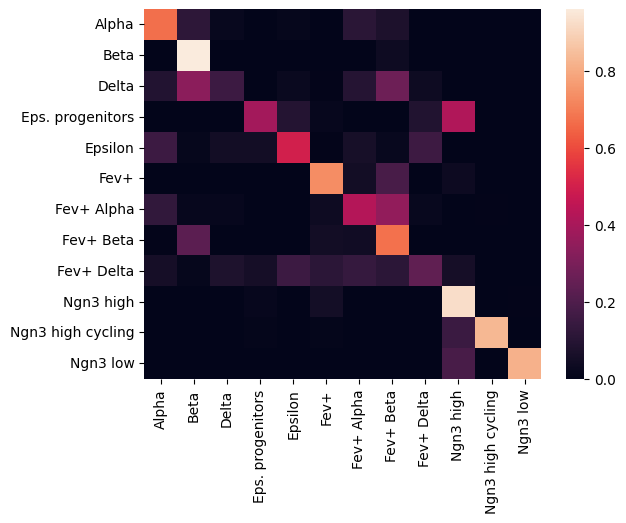

In [132]:
sns.heatmap(cell_transition)

In [ ]:
1